### Loading data (matches) from the backend api

In [268]:
import requests
import json

leagueId="6250d82b81afe4381753aefa"
r = requests.get(f'http://localhost:3000/football/{leagueId}/all/matches')
json_matches=json.loads(r.text)

### Cleaning and filtering and preprocessing data

In [269]:
from datetime import datetime

json_data = []
for json_match in json_matches:
    clean_match = {}
    if(json_match['finished'] == False):
        continue
    clean_match['homeTeam'] = json_match['homeTeam']['name']
    clean_match['awayTeam'] = json_match['awayTeam']['name']
    clean_match['date']=datetime.strptime(json_match['date'],'%Y-%m-%dT%H:%M:%S.%fZ').toordinal()
    clean_match['homeTeamGoals'] = len(
        list(filter(lambda goal: goal['homeTeam'] == True, json_match['goals'])))
    clean_match['awayTeamGoals'] = len(
        list(filter(lambda goal: goal['homeTeam'] == False, json_match['goals'])))
    json_data.append(clean_match)



### Create targets 
- result in ['home','draw','away']
- over0.5 in [0,1]

In [270]:
result_target=[]    # contain match result ('home','draw','away') 
over05_target=[]    # contain if goals sum is over 0.5
over15_target=[]    # contain if goals sum is over 1.5
over25_target=[]    # contain if goals sum is over 2.5
over35_target=[]    # contain if goals sum is over 3.5
# this targets support double prediction example 1x 12 x2
home_target=[]      
draw_target=[]
away_target=[]

for match in json_data:
    if(match['homeTeamGoals'] > match['awayTeamGoals']):
        result_target.append('home')
        home_target.append(1)      
        draw_target.append(0)
        away_target.append(0)
    elif(match['homeTeamGoals'] < match['awayTeamGoals']):
        result_target.append('away')
        home_target.append(0)
        draw_target.append(0)
        away_target.append(1)
    else:
        home_target.append(0)
        draw_target.append(1)
        away_target.append(0)
        result_target.append('draw')
        
    goals_sum=match['homeTeamGoals'] + match['awayTeamGoals']
    if(goals_sum>0.5):
        over05_target.append(1)
    else:
        over05_target.append(0)
        
    if(goals_sum>1.5):
        over15_target.append(1)
    else:
        over15_target.append(0)
        
    if(goals_sum>2.5):
        over25_target.append(1)
    else:
        over25_target.append(0)
        
    if(goals_sum>3.5):
        over35_target.append(1)
    else:
        over35_target.append(0)

   
targets={
    'result':result_target,
    'over 0.5':over05_target,
    'over 1.5':over15_target,
    'over 2.5':over25_target,
    'over 3.5':over35_target,
    'home':home_target,
    'away':draw_target,
    'draw':away_target,
    
}

### Restructuring data to pandas Dataframe

In [271]:
import pandas as pd

data=[]
home_team = []
away_team = []
date=[]
for match in json_data:
    home_team.append(match['homeTeam'])
    away_team.append(match['awayTeam'])
    date.append(match['date'])

data = pd.DataFrame({
    'homeTeam': home_team, 
    'awayTeam': away_team,
    'date':date
    
})

print(data)




             homeTeam     awayTeam    date
0          costa-rica          usa  738245
1             jamaica     honduras  738245
2              mexico  el-salvador  738245
3              panama       canada  738245
4     solomon-islands  new-zealand  738244
...               ...          ...     ...
4394         colombia       brazil  731465
4395          uruguay      bolivia  731465
4396             peru     paraguay  731465
4397          ecuador    venezuela  731464
4398        argentina        chile  731464

[4399 rows x 3 columns]


### Convert categorical variable into dummy/indicator variables.

In [272]:

data=pd.get_dummies(data)

### Preprocessing :Normalize date column

In [273]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaler.fit(data)
scaled = scaler.transform(data)
data = pd.DataFrame(scaled, columns=data.columns)

print(data)

          date  homeTeam_afghanistan  homeTeam_albania  homeTeam_algeria  \
0     1.000000                   0.0               0.0               0.0   
1     1.000000                   0.0               0.0               0.0   
2     1.000000                   0.0               0.0               0.0   
3     1.000000                   0.0               0.0               0.0   
4     0.999853                   0.0               0.0               0.0   
...        ...                   ...               ...               ...   
4394  0.000147                   0.0               0.0               0.0   
4395  0.000147                   0.0               0.0               0.0   
4396  0.000147                   0.0               0.0               0.0   
4397  0.000000                   0.0               0.0               0.0   
4398  0.000000                   0.0               0.0               0.0   

      homeTeam_andorra  homeTeam_angola  homeTeam_anguilla  \
0                  0.0   

### Naive bayes classifier average score

In [280]:
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split

def average_score(classifier, data, target):
    sum = 0
    cycles = 300

    for i in range(1, cycles):

        train_data, test_data, train_target, test_target = train_test_split(
            data, target, test_size=0.2)
        classifier.fit(train_data, train_target)
        sum += classifier.score(test_data, test_target)
        
    return sum/cycles



nb_clf = naive_bayes.MultinomialNB(fit_prior=True)
naive_bayes_scores=[]

for target_label in targets:
    score=round(average_score(nb_clf,data,targets[target_label]),2)
    naive_bayes_scores.append(score)
    print(f'score for {target_label} : {score}')


score for result : 0.55
score for over 0.5 : 0.64
score for over 1.5 : 0.59
score for over 2.5 : 0.69
score for over 3.5 : 0.81
score for home : 0.71
score for away : 0.6
score for draw : 0.81


### Random forest classifier score

In [275]:
from sklearn.ensemble import RandomForestClassifier

rf_clf=RandomForestClassifier(n_estimators=100)

random_forest_scores=[]

for target_label in targets:
    
    train_data, test_data, train_target, test_target = train_test_split(
        data, targets[target_label], test_size=0.3)
    rf_clf.fit(train_data, train_target)
    score=round(rf_clf.score(test_data,test_target),2)
    random_forest_scores.append(score)
    print(f'score for {target_label} : {score}')

score for result : 0.69
score for over 0.5 : 0.92
score for over 1.5 : 0.82
score for over 2.5 : 0.72
score for over 3.5 : 0.81
score for home : 0.81
score for away : 0.82
score for draw : 0.83


### Decision tree classifier score

In [276]:
from sklearn.tree import DecisionTreeClassifier

dt_clf= DecisionTreeClassifier()


decision_tree_scores=[]

for target_label in targets:
    
    train_data, test_data, train_target, test_target = train_test_split(
        data, targets[target_label], test_size=0.3)
    dt_clf.fit(train_data, train_target)
    score=round(dt_clf.score(test_data,test_target),2)
    decision_tree_scores.append(score)
    print(f'score for {target_label} : {score}')



score for result : 0.66
score for over 0.5 : 0.9
score for over 1.5 : 0.76
score for over 2.5 : 0.72
score for over 3.5 : 0.77
score for home : 0.76
score for away : 0.78
score for draw : 0.81


### SVC classifier score

In [277]:
from sklearn.svm import SVC

svc_clf=SVC()
svc_scores=[]


for target_label in targets:
    
    train_data, test_data, train_target, test_target = train_test_split(
        data, targets[target_label], test_size=0.3)
    svc_clf.fit(train_data, train_target)
    score=round(svc_clf.score(test_data,test_target),2)
    svc_scores.append(score)
    print(f'score for {target_label} : {score}')

score for result : 0.7
score for over 0.5 : 0.9
score for over 1.5 : 0.78
score for over 2.5 : 0.71
score for over 3.5 : 0.82
score for home : 0.76
score for away : 0.81
score for draw : 0.83


### LogisticRegression classifier score

In [278]:
from sklearn.linear_model import LogisticRegression


lr_clf=LogisticRegression()
logistic_regression_scores=[]

for target_label in targets:
    
    train_data, test_data, train_target, test_target = train_test_split(
        data, targets[target_label], test_size=0.3)
    lr_clf.fit(train_data, train_target)
    score=round(lr_clf.score(test_data,test_target),2)
    logistic_regression_scores.append(score)
    print(f'score for {target_label} : {score}')


score for result : 0.68
score for over 0.5 : 0.88
score for over 1.5 : 0.74
score for over 2.5 : 0.72
score for over 3.5 : 0.82
score for home : 0.76
score for away : 0.78
score for draw : 0.85


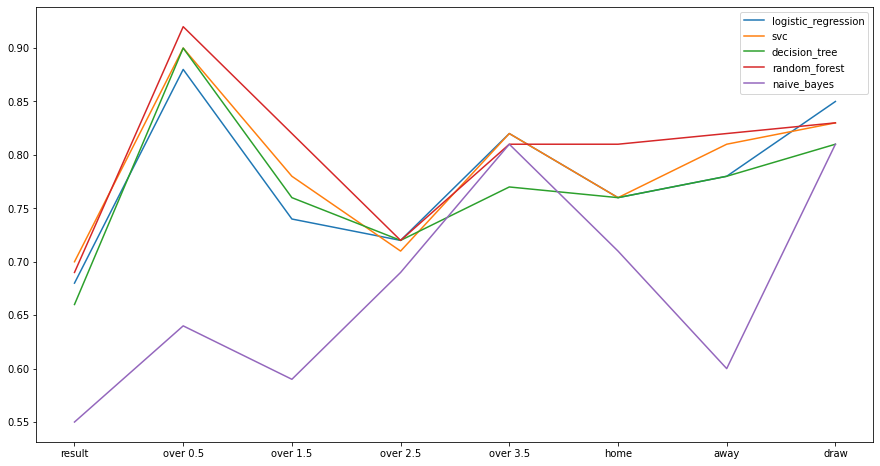

In [281]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

plt.plot(targets.keys(), logistic_regression_scores, label = "logistic_regression")
plt.plot(targets.keys(), svc_scores, label = "svc")
plt.plot(targets.keys(), decision_tree_scores, label = "decision_tree")
plt.plot(targets.keys(), random_forest_scores, label = "random_forest")
plt.plot(targets.keys(), naive_bayes_scores, label = "naive_bayes")
plt.legend()